In [188]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [189]:
name='cifar10'

In [190]:
download_url("https://files.fast.ai/data/examples/cifar10.tgz", '.')
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
classes = os.listdir("./data/cifar10/train")

Using downloaded and verified file: .\cifar10.tgz


In [191]:
sts = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
t_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), tt.RandomHorizontalFlip(),  tt.ToTensor(),  tt.Normalize(*sts,inplace=True)])
v_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*sts)])

In [192]:
v_ds = ImageFolder(data_dir+'/test', v_tfms)

t_ds = ImageFolder(data_dir+'/train', t_tfms)


In [193]:
size = 400

In [194]:
v_dl = DataLoader(v_ds, size*2, num_workers=3, pin_memory=True)

t_dl = DataLoader(t_ds, size, shuffle=True, num_workers=3, pin_memory=True)


In [195]:
def show(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


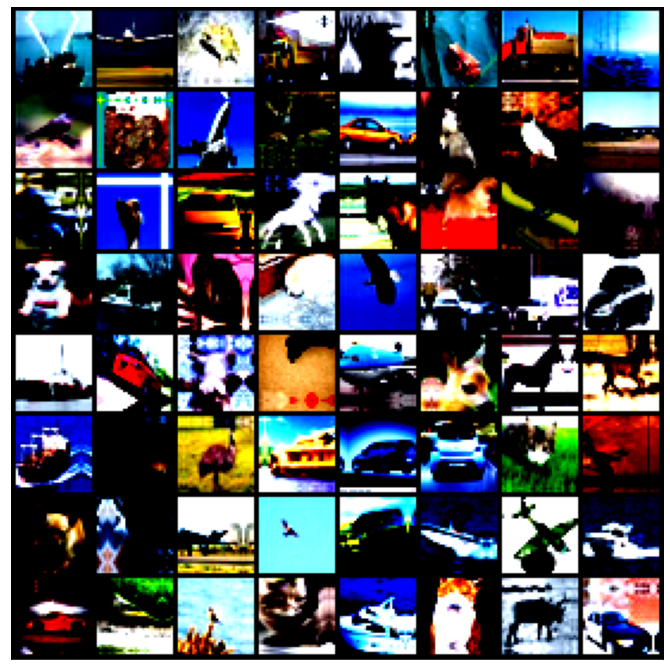

In [196]:
show(t_dl)

In [197]:
def get_device():
    if not torch.cuda.is_available():
        return torch.device('cpu')
    else:
        return torch.device('cuda')
    



In [198]:
def swapDevice(data, device):
    if not isinstance(data, (list,tuple)):
      return data.to(device, non_blocking=True)
    else:
      return [swapDevice(x, device) for x in data]


In [199]:
class DeviceDataLoader():
    def __len__(self):
        return len(self.dl)  
        
    def __iter__(self):
        for b in self.dl: 
            yield swapDevice(b, self.device)

  
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

In [200]:
train_dl = DeviceDataLoader(train_dl, get_device())
valid_dl = DeviceDataLoader(valid_dl, get_device())

In [201]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu2 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x 

In [202]:
simple_resnet = swapDevice(SimpleResidualBlock(), get_device())

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [203]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [204]:
class ImageClassificationBase(nn.Module):
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
            
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    


In [205]:
def conv(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),nn.BatchNorm2d(out_channels),nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [206]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv(in_channels, 64)
        self.conv2 = conv(64, 128, pool=True)
        self.res1 = nn.Sequential(conv(128, 128), conv(128, 128))
        self.conv3 = conv(128, 256, pool=True)
        self.conv4 = conv(256, 512, pool=True)
        self.res2 = nn.Sequential(conv(512, 512), conv(512, 512))
        self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(), nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [207]:
model = swapDevice(ResNet9(3, 10), device)

In [208]:
@torch.no_grad()
def evaluate(m, l):
    m.eval()
    outputs = [m.validation_step(batch) for batch in l]
    return m.validation_epoch_end(outputs)


In [209]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [210]:
def foc(number_of_epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    h = []

    opt = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    sc = torch.optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs,  steps_per_epoch=len(train_loader))
    
    for epoch in range(number_of_epochs):
        # Training Phase 
        model.train()
        ls = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            ls.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)    
            opt.step()
            opt.zero_grad()
            lrs.append(get_lr(opt))
            sc.step()

        r = evaluate(model, val_loader)
        r['train_loss'] = torch.stack(ls).mean().item()
        r['lrs'] = lrs
        model.epoch_end(epoch, r)
        h.append(r)
    return h

In [213]:
weight_decay = 1e-4
opt_func = torch.optim.Adam
grad_clip = 0.1
number_of_epochs = 30
lr = 0.01

In [ ]:
%%time
history += foc(number_of_epochs, lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00069, train_loss: 0.0438, val_loss: 0.2759, val_acc: 0.9215
Epoch [1], last_lr: 0.00152, train_loss: 0.0709, val_loss: 0.3732, val_acc: 0.9013
Epoch [2], last_lr: 0.00279, train_loss: 0.1576, val_loss: 0.4527, val_acc: 0.8621
Epoch [3], last_lr: 0.00436, train_loss: 0.2527, val_loss: 0.4976, val_acc: 0.8541
Epoch [4], last_lr: 0.00603, train_loss: 0.3112, val_loss: 0.7998, val_acc: 0.7776
Epoch [5], last_lr: 0.00760, train_loss: 0.3419, val_loss: 0.5532, val_acc: 0.8250
Epoch [6], last_lr: 0.00888, train_loss: 0.3499, val_loss: 0.5006, val_acc: 0.8365
Epoch [7], last_lr: 0.00971, train_loss: 0.3575, val_loss: 0.6751, val_acc: 0.7930
Epoch [8], last_lr: 0.01000, train_loss: 0.3623, val_loss: 0.7169, val_acc: 0.7910
Epoch [9], last_lr: 0.00994, train_loss: 0.3667, val_loss: 0.4620, val_acc: 0.8464
Epoch [10], last_lr: 0.00978, train_loss: 0.3548, val_loss: 0.7121, val_acc: 0.7827
Epoch [11], last_lr: 0.00950, train_loss: 0.3520, val_loss: 0.4886, val_acc: 0.8406
